In [1]:
import numpy as np
import sisl
import z2pack

# Calculating the $\mathbb{Z}_2$ invariant 
In this excercise we will use Z2Pack to calculate the $\mathbb{Z}_2$ topological invariant of the monolayer bismuth structure from the last excercise. 

## Introduction

### Hybrid Wannier Charge centres

Z2Pack uses hybrid Wannier charge centres (HWCC) to calculate topological invariants. Hybrid Wannier function (HWF) are defined similary to Wannier function (WF). However, they are only localized in one direction and delocalized in the others. 

\begin{align}
|(R_x,k_y), n\rangle = \frac{1}{2\pi}\int\mathrm{d}k_x\; e^{i k_x R_x}|\psi_{n,\mathbf{k}}\rangle
\end{align}

The charge centre of an HWF is defined as the average position of the function in the localized direction. They defined only modulo the lattice vector $a_x$.

\begin{align}
\bar x_n(k_y) = \langle (R_x,k_y), n | \hat{x} | (R_x,k_y), n\rangle
\end{align}

One can think of an HWCC as the charge center of a Wannier function in a 1D system, which is coupled to an external parameter $k_y$. In this interpretation, the sum of all HWCCs is directly linked to the 1D electronic polarization
\begin{align}
\mathbf{P}^h_e(k_y) = e \sum_n \bar x_n(k_y)
\end{align}
It should be noted that individual HWCCs are not gauge invariant. The sum of all HWCCs and $\mathbf{P}^h_e(k_y)$ are gauge invariant. 

### From HWCC to topological invariants
#### Chern number

Since the HWCCs are defined only modulo the lattice vector $R_x$, we can assume periodic boundary conditions $\bar x(k_y) = \bar x(k_y) + a_x$. This way $\bar x(k_y)$ can be mapped on a point on the unit circle for any given $k_y$. As $k_y$ goes from 0 to $2\pi$ the HWCCs and $P^h_e$ describe trajectories on a cylinder. The winding number of the trajectory of $P^h_e$ gives the Chern number of the system. 

<img src="img/FIG_2_Gresch_PhyRevB95_075146_2017.png" alt="Sketch of some possible evolutions of $P^h_e$" style="width: 400px;"/>

A Chern number can also be uniquely associated with any set of **isolated bands** and corresponds to the number of windings of the polarization of the subset of states. The Chern number of the whole system is equal to sum of the individual Chern numbers.

#### Time-reversal invariance and the $\mathbb{Z}_2$-invariant

Under time-reversal symmetry the Hilberterspace of occupied states can be split into two subspaces which are mapped on to each other by time-reversal. This splits all Kramer pairs into states which are assigned different subspaces. The Chern number $C_1$, $C_2$ of the subspaces are not uniquely defined and depend on which states are assigned to which subspace. However, as a consequence of the Chern number being odd under time-reversal, the two Chern numbers are always opposits $C_1=-C_2$. I.e. the Chern number of the full system is always 0.

Further, the two states forming a Kramer pair have to carry oppoiste Chern numbers. Hence, if the states exchange subspaces, the two Chern numbers can only change by an even number. I.e. the $\mathbb{Z}_2$ invariant
\begin{align}
\mathbb{Z}_2 = (C_1 - C_2)/2 (\textrm{mod} 2)
\end{align}
is well defined.

Geometrically the $\mathbb{Z}_2$ invariant is related to the number of times L any line $f(k_y)$ intersects the trajectory of HWCCs on the interval $[0,2\pi]$. 

<img src="img/FIG_5_Gresch_PhyRevB95_075146_2017.png" alt="Sketch of some possible evolutions of $P^h_e$" style="width: 400px;"/>

Note: In Z2Pack $f(k_y)$ is defined as the middle of the largest gap between two neighbhouring HWCCs. This choice is favorable for numerical stability.

_References for content and images:_
1. Dominik Gresch et al., Phys. Rev. B **95**, 075146 (2017), "Z2Pack: Numerical implementation of hybrid Wannier centers for identifying topological materials", doi: [10.1103/PhysRevB.95.075146](https://doi.org/10.1103/PhysRevB.95.075146)

## Hands-on tutorial

In order to run Z2Pack we need to provide information about the Hamiltonian, overlap and the orbital positions.
We start off by reading the geometry and hamiltonian from siesta output.

In [2]:
sile = sisl.get_sile('Siesta/Bi2D_BHex.fdf')
geom = sile.read_geometry()
H = sile.read_hamiltonian(geometry=geom)

We will create a ``hm`` system in Z2Pack ([doc](http://z2pack.ethz.ch/doc/2.1/reference/hm.html)). This interface expects two functions: one returning the Hamiltonian matrix and one the overlap matrix for any given k-vector.


In [3]:
Hk = lambda k: H.Hk(k=k, dtype=np.complex64, format='array')
Sk = lambda k: H.Sk(k=k, dtype=np.complex64, format='array')

Next, we need the positions of all orbitals in fractional coordinates. Note, that the matrix elements are ordered in 2x2 blocks corresponding to spin-up and spin-down version of the same basis orbital. So we need to create a list of positions with the same order.

In [4]:
pos = geom.fxyz[list(map(geom.o2a, np.arange(H.no)))]
pos = np.repeat(pos, 2, axis=0)

Now, we can create the system in Z2Pack. For now, we will only look at the two highest occupied bands. They are degenearte (Kramer degeneracy) and isolated from the rest of the occupied bands, which allows us to uniquely associate a $\mathbb{Z}_2$ invariant with this pair.


In [5]:
system_hocc = z2pack.hm.System(
        hamilton=Hk,
        hermitian_tol=1e-5,
        overlap=Sk,
        pos=pos,
        bands=[28,29],
)

### Running a HWCC calculation
In order to get the $\mathbb{Z}_2$ invariant, we need to specify 
1. in which direction the trajectories of the HWF should be evaluated and
2. in which direction the integral, which gives the HWFs, should be performed.

This defines a surface in k-space, which is periodic in one direction and covers half of the BZ in the other. To pass this information to Z2Pack, 
we need to define a function $S$ that is periodic in the second argument and covers half a period in the second argument. The domain is always $[0,1]^2$ and the function has to map onto vectors in reciprocal space (in fractional coordinates).
\begin{align}
&S: [0,1]^2 \rightarrow \mathbb{R}^3 \\
&S(s,1) = S(s,0) + \mathbf{G} \\
&S(1,t) = S(0,t) + \frac{1}{2}\mathbf{G}'
\end{align}

In our example we want to calculate the HWCCs along $k_x$ and trace the evolutions for $k_y$ from $0$ to $\pi$.
\begin{align}
&S(s,1) = S(s, 0) + (1, 0, 0) \\
&S(1,t) = S(0,t) + (0, 0.5, 0)
\end{align}

In [6]:
surface=lambda s, t: [t, s/2, 0]

There are three diffrent convergence criteria in Z2Pack:
1. Positions of the HWCCs on a line: The code checks how much the positions of the HWCCs change as the as more k-points are used. The tolerance for this check is set by the flag ``pos_tol``. If the change is larger than the tolerance more k-points will be use. The numbers of k-point are controlled via the flag ``iterator``. 
2. Movement of the HWCCs between lines: The code checks how much the position of the HWCCs changes from one line to the next. The tolerance for this check is set by the flag ``move_tol``. If the check fails a new line is added in between. The initial number of lines is controlled via the flag ``num_lines`` and the lower limit for the distance between two line is controll via ``min_neighbour_dis``.
3. Gap position: The code check how big the distance between the position of the gap and the position of HWCCs in neighbouring lines are. The tolerance for this check is set by the flag ``gap_tol``. If the check fails a new line is added in between. The initial number of lines is controlled via the flag ``num_lines`` and the lower limit for the distance between two line is controll via ``min_neighbour_dis``.

In [7]:
# Run the WCC calculations
settings = {'num_lines': 11,
            'pos_tol': 1e-2,
            'gap_tol': 2e-2,
            'move_tol': 0.3,
            'iterator': range(8, 27, 2),
            'min_neighbour_dist': 1e-2,
            'load': False,
}

result_hocc = z2pack.surface.run(
    system=system_hocc,
    surface=surface,
    save_file='./res_hocc.json',
    **settings
)


+----------------------------------------------------------------------+
|     ===================                                              |
|     SURFACE CALCULATION                                              |
|     ===================                                              |
|     starting at 2020-02-20 18:03:31,478                              |
|     running Z2Pack version 2.1.1                                     |
|                                                                      |
|     gap_tol:            0.02                                         |
|     init_result:        None                                         |
|     iterator:           range(8, 27, 2)                              |
|     load:               False                                        |
|     load_quiet:         True                                         |
|     min_neighbour_dist: 0.01                                         |
|     move_tol:           0.3                     

In [8]:
print("Z2 invariant of the two highest, occupied bands: {}".format(z2pack.invariant.z2(result_hocc)))

Z2 invariant of the two highest, occupied bands: 1


We can visualize the HWCCs and the gap position:

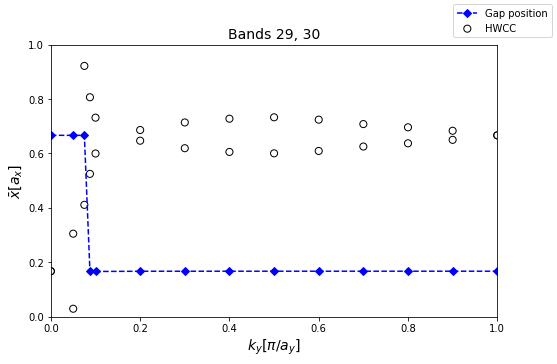

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8,5))
wcc_settings={'s': 50., 'lw': 1., 'facecolor': 'none', 'edgecolors': 'k', 'label':'HWCC'}
gap_settings={'marker': 'D', 'color': 'b', 'linestyle': '--', 'label':'Gap position'}

z2pack.plot.wcc(result_hocc, axis=ax, wcc_settings=wcc_settings, gap_settings=gap_settings)
ax.set_title('Bands 29, 30', fontsize=14)
ax.set_ylabel(r'$\bar{x} [a_x]$', fontsize=14)
ax.set_xlabel(r'$k_y [\pi/a_y]$', fontsize=14)
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys())
plt.show()

## Exercises
1. To get a feeling for the different options, you should play with them. Use a small number of lines and try different combinations of parameters. Even if the calculations did not converge, you can plot the HWCCs. This allows you to see why a certain check failed.

2. Calculate the invariance for the whole system. You can either look at the invariants for each pair of bands or try to treat multiple ones at the same time. You can go back to the last exercise to have another look at the band structure.

_Hint: Running a calculation with all 30 bands, might be tricky to converge._